In [24]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders, get_FMNIST_loaders, get_CIFAR100_loaders, get_CIFAR10_loaders
from lib.model import ANN
from lib.train import train
from lib.test import test
from lib.growth_schedules import get_CL_schedule
from lib.visualize import (visualize_pathes,
                          visualize_statistical_reliability,
                          visualize_box_plot)               

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = get_device()

In [3]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"

# MNIST

## Get data loaders

In [4]:
batch_size=128

In [5]:
# Get data for task 2
train_loader_0_to_4, val_loader_0_to_4, test_loader_0_to_4 = get_MNIST_loaders(data_path, range(5), batch_size)
train_loader_0_to_9, val_loader_0_to_9, test_loader_0_to_9 = get_MNIST_loaders(data_path, range(10), batch_size)

train_loaders, val_loaders, test_loaders = [], [], []

for i in range(10) :
    class_name = [i]
    train_loader, val_loader, test_loader = get_MNIST_loaders(data_path, [i], batch_size)
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
    test_loaders.append(test_loader)

## Random Initialization

In [13]:
init_name = "random"
savefig = "MNIST_random_CL"

### Define, train and test both root & target models

In [14]:
# Network's initial architecture
num_inputs = 28*28
num_hidden = 50
num_outputs = 10

# Network's final architecture
num_hidden_target = 95

# Loss & optimizer
loss_name = "MSE" # "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3
growth_schedule = None

# Experiment parameters
num_repetitions = 1

#### Root model

#### Target model

### Grow root model

In [106]:
# Growth parameters
num_neurons = 9
lr_root = 2e-3

In [107]:
growth_schedules = get_CL_schedule(num_neurons)

In [112]:
test_accs_matrices_repeted = []
for i in range(num_repetitions) :
    test_accs_matrices = []
    for growth_schedule in growth_schedules :
        # Define & pretrain the root model
        root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
        _ = train(root_model, num_outputs, None, loss_name, optimizer_name, lr_root, train_loader_0_to_4, val_loader_0_to_4, num_epochs, batch_size, device, verbose=0)
        # Initialize the matrix containing test accuracies on various task
        test_accs_matrix = np.zeros((6,10))
        for j in range(5) :
            test_accs_matrix[0,j] = round(test(root_model, test_loaders[j], batch_size, device),2)
        for i, train_loader, val_loader in zip(range(5,6), train_loaders[5:], val_loaders[5:]):
            print("iteration :", i)
            lr_growth = 5*1e-4
            _ = train(root_model,
                      num_outputs,
                      growth_schedule[i-5],
                      loss_name, 
                      optimizer_name, lr_growth, 
                      train_loaders[i], val_loaders[i], 
                      2, batch_size, 
                      device,
                      init_name=init_name,
                      verbose=0)
            for j in range(i+1) :
                test_accs_matrix[i-4,j] = round(test(root_model, test_loaders[j], batch_size, device),2)
        test_accs_matrices.append(test_accs_matrix)
    test_accs_matrices_repeted.append(test_accs_matrices)

  0%|          | 0/3 [00:00<?, ?it/s]

grad : tensor([ 0.0002,  0.0002, -0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0001,
         0.0002,  0.0002], device='cuda:0')


 33%|███▎      | 1/3 [00:03<00:07,  3.97s/it]

grad : tensor([ 2.1808e-05,  8.2702e-05, -2.1612e-04,  6.6783e-05,  3.1259e-05,
         2.7453e-06,  6.0796e-06,  1.9387e-06,  2.9558e-06,  2.3296e-06],
       device='cuda:0')


 67%|██████▋   | 2/3 [00:08<00:04,  4.48s/it]

grad : tensor([ 1.6412e-05,  7.2792e-06,  1.6148e-05, -2.9530e-05,  2.3266e-06,
         1.5781e-06,  1.9945e-06,  7.4677e-07,  1.8659e-06,  1.5126e-06],
       device='cuda:0')


100%|██████████| 3/3 [00:13<00:00,  4.56s/it]


iteration : 5


 50%|█████     | 1/2 [00:00<00:00,  1.18it/s]

grad : tensor([ 1.4467e-07,  6.0090e-06,  1.7918e-05,  2.0839e-05,  2.2710e-04,
        -1.7581e-04,  1.0278e-08,  4.2677e-07,  2.0321e-07,  2.9235e-06],
       device='cuda:0')


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


In [113]:
print(test_accs_matrices_repeted[0][0])

[[99.44 99.02 95.41 96.76 98.77  0.    0.    0.    0.    0.  ]
 [41.97  5.96 90.33 50.89 89.28 89.97  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


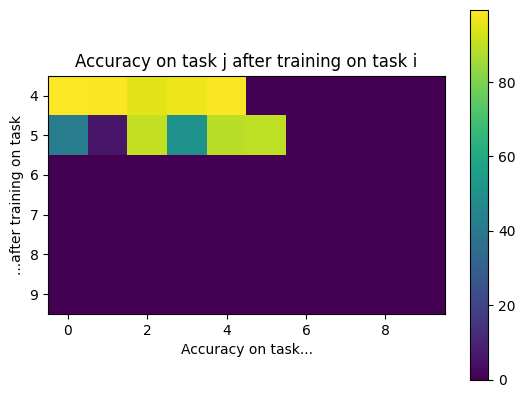

In [114]:
plt.imshow(test_accs_matrices_repeted[0][0], cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()

In [115]:
np.array(test_accs_matrices_repeted[0][0]).sum(axis=1)

array([489.4, 368.4,   0. ,   0. ,   0. ,   0. ])

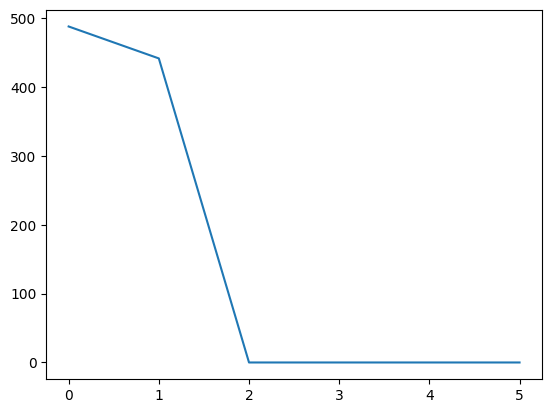

In [99]:
plt.plot(np.array(test_accs_matrices_repeted[0][0]).sum(axis=1))

In [75]:
root_model.named_parameters

<bound method Module.named_parameters of ANN(
  (fc1): Linear(in_features=784, out_features=95, bias=True)
  (fc2): Linear(in_features=95, out_features=95, bias=True)
  (fc3): Linear(in_features=95, out_features=10, bias=True)
)>

In [ ]:
for j in range(10) :
    i = 0
    for b in train_loaders[j] :
        i += 1
    print(i)

### Visualize results